In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from powderworld import PowderWorld, PowderWorldRenderer
import powder_dists
import torch
import numpy as np
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gym import spaces

In [3]:
import powder_env
import envs

In [49]:
from tqdm.auto import tqdm

In [4]:
device = 'cuda:3'

In [5]:
pw = PowderWorld(device)
pwr = PowderWorldRenderer(device)

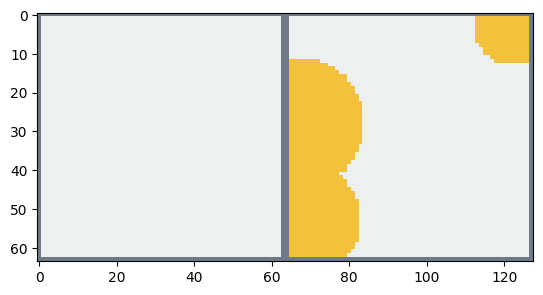

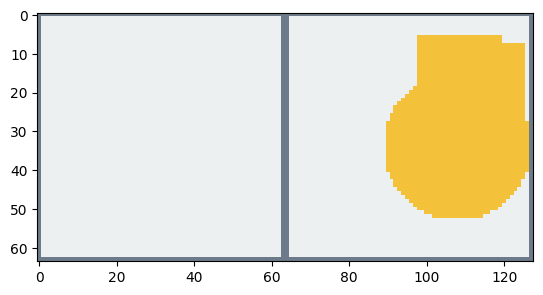

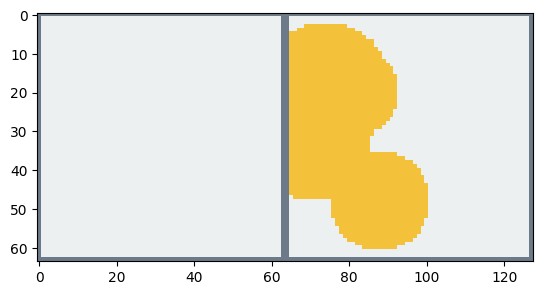

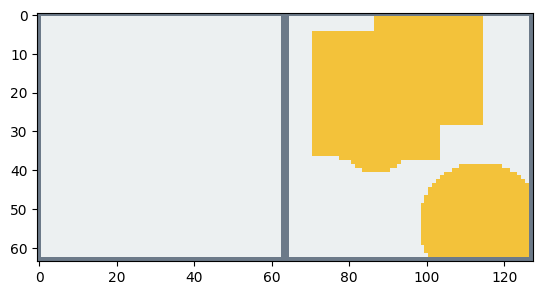

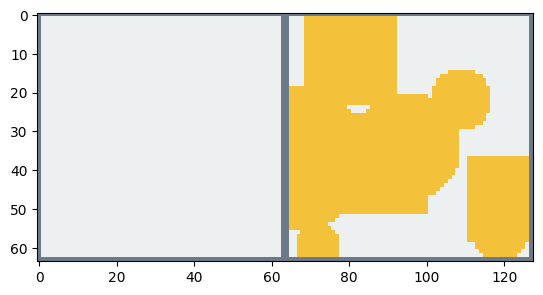

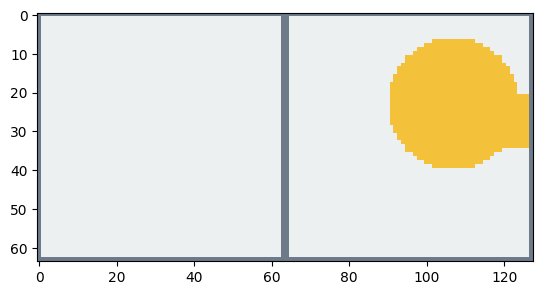

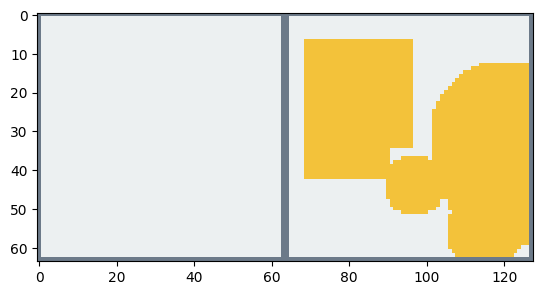

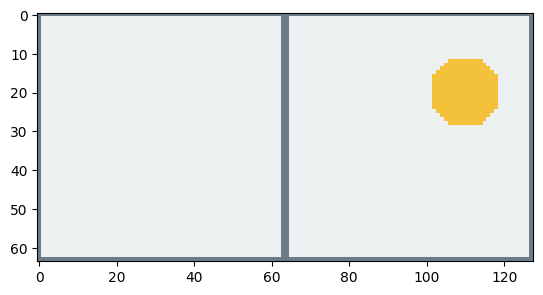

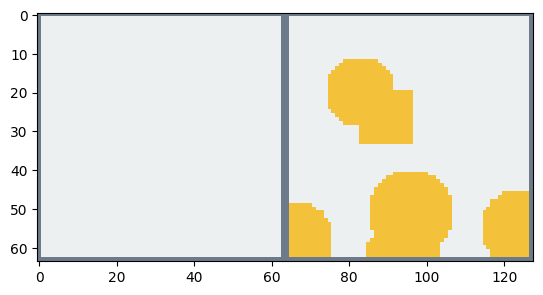

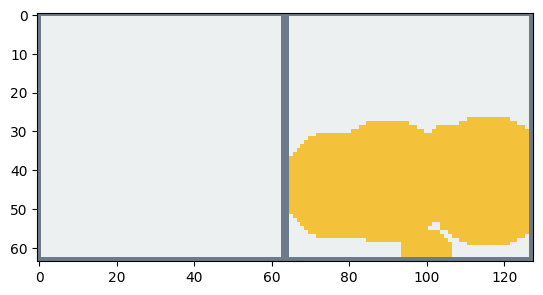

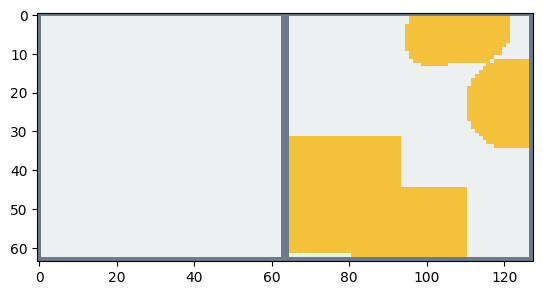

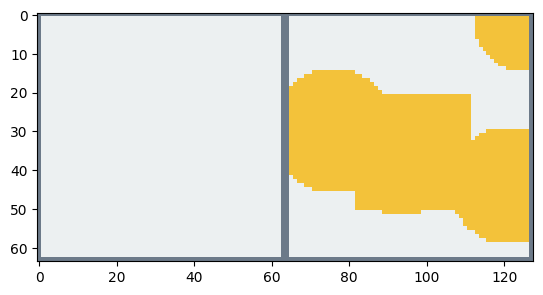

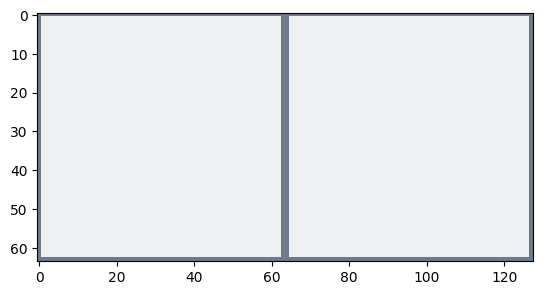

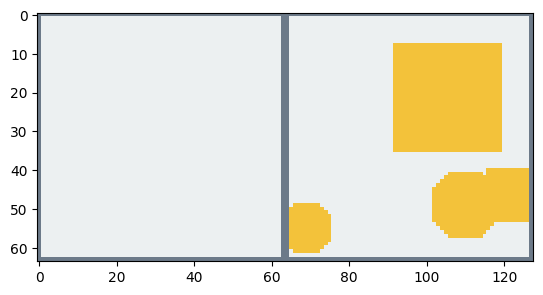

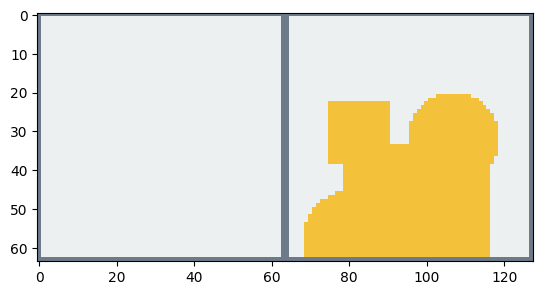

In [48]:
kwargs_pcg = dict(hw=(64,64), elems=['sand'], num_tasks=100000, 
                  num_lines=0, num_circles=5, num_squares=5, has_empty_path=False)

for i in range(15):
    env = envs.PWDrawEnv(False, kwargs_pcg)
    env.reset()
    plt.imshow(env.render())
    plt.show()

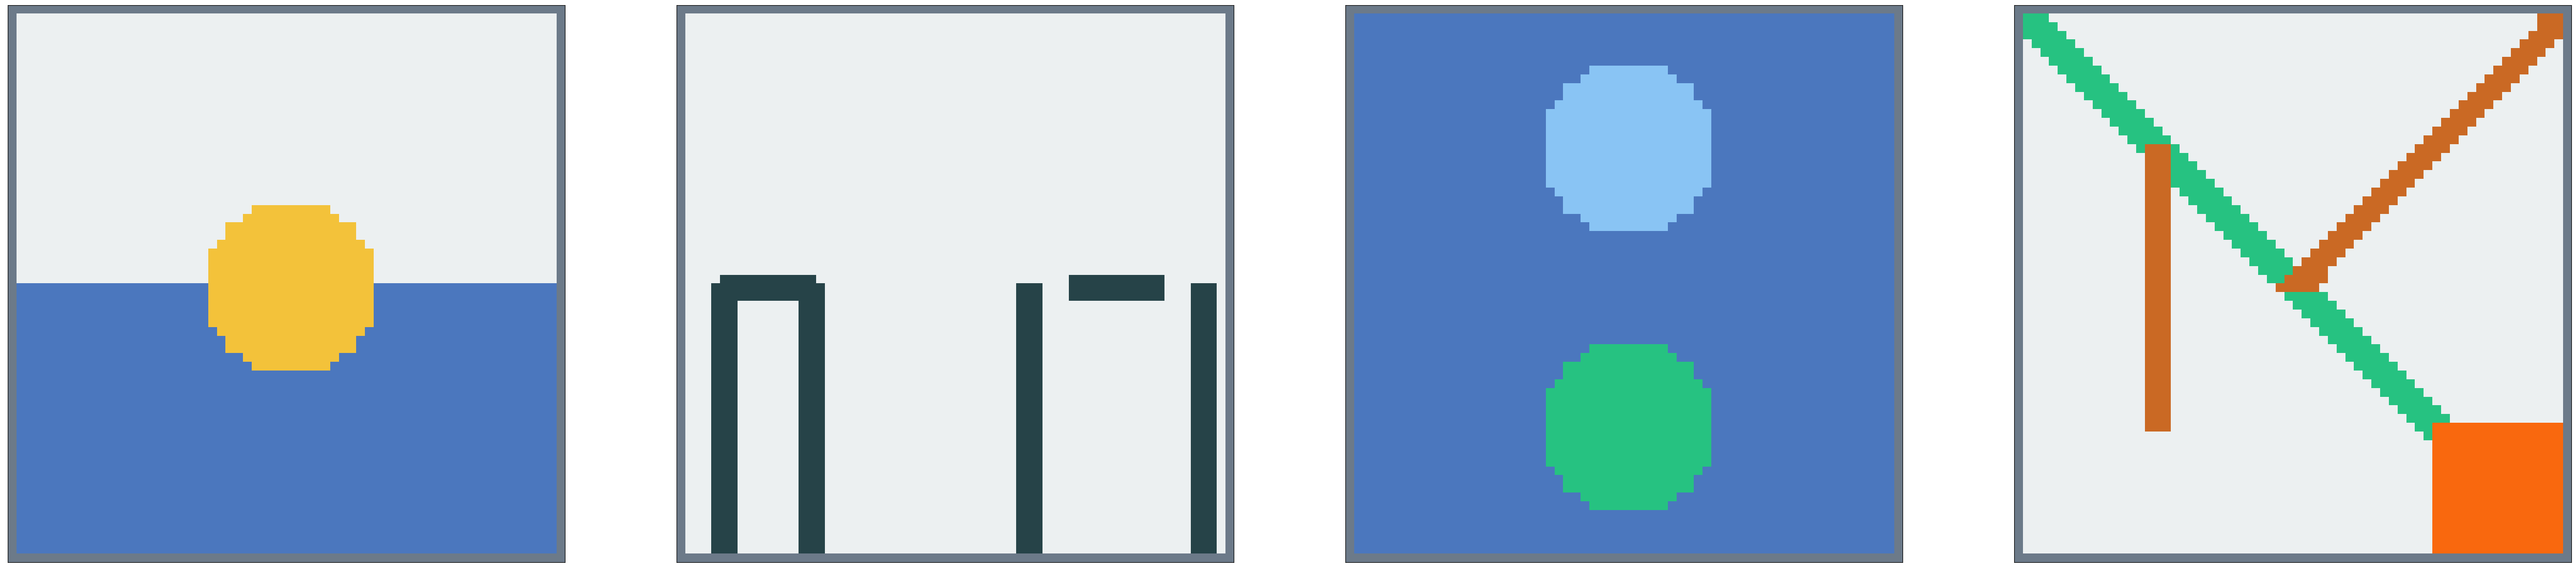

Slow run to compile JIT.


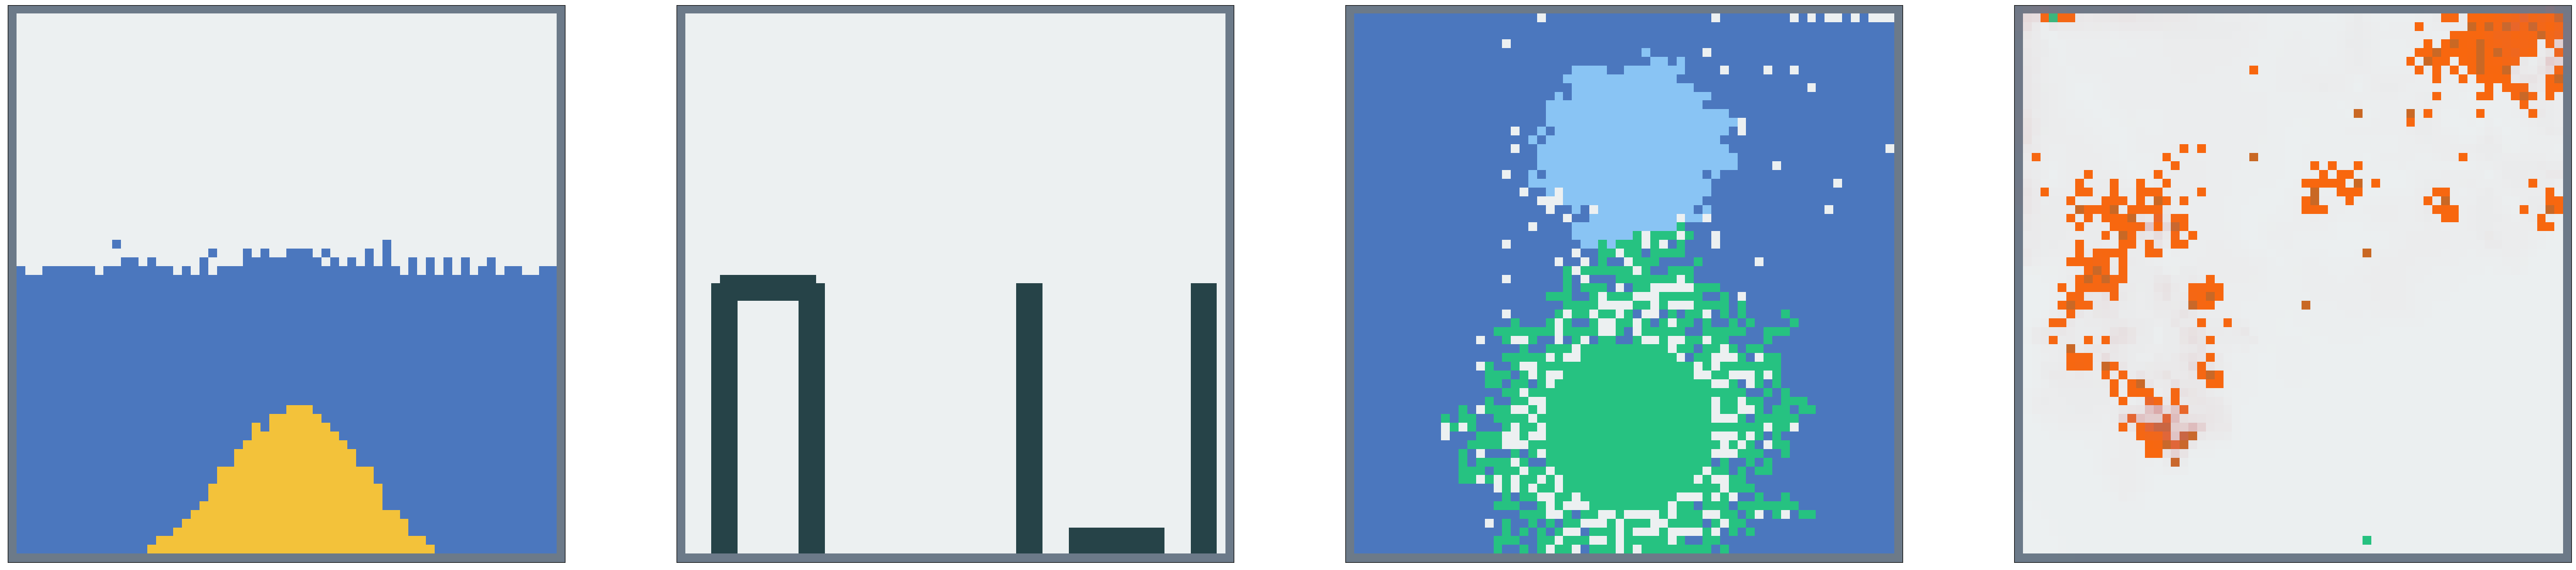

In [5]:

def show_row(world, name='dist', size=4):
    imgs = [pwr.render(world[x:x+1]) for x in range(size)]
    fig = plt.figure(figsize=(16*size,16))
    axarr = fig.subplots(1, size)
    for b in range(size):
        axarr[b].imshow(imgs[b])
        axarr[b].get_xaxis().set_visible(False)
        axarr[b].get_yaxis().set_visible(False)
    del imgs
    # fig.show()
    # fig.savefig('figs/{}.png'.format(name))
    plt.show()
    del fig
    
world = torch.zeros((4, pw.NUM_CHANNEL, 64, 64), dtype=torch.float32, device=device)
for b in range(4):
    powder_dists.make_test(pw, world[b:b+1], b)
show_row(world)
for t in range(64):
    world = pw(world)
show_row(world)

In [6]:
env = powder_env.PowderWorldSandEnv(test=False)
print(env.reset().shape)

(32, 20, 64, 64)


In [7]:
plt.imshow(pwr.render(env.world[[9]]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:3! (when checking argument for argument weight in method wrapper__cudnn_convolution)

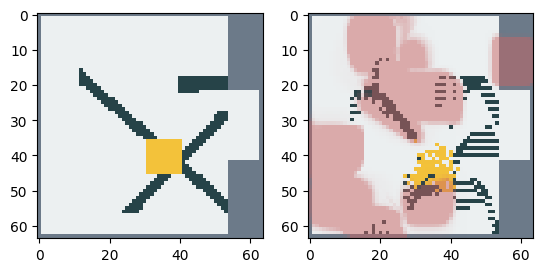

In [5]:
env = envs.PWSandEnv(batch_size=1, device=device)
obs = env.reset()
plt.subplot(121)
plt.imshow(env.render())
for _ in range(10):
    obs, reward, done, info = env.step(env.action_space.sample())
plt.subplot(122)
plt.imshow(env.render())

  0%|          | 0/63 [00:00<?, ?it/s]

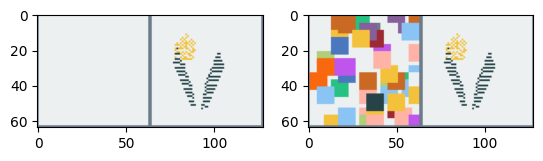

[-13.148]


In [6]:
env = envs.PWDrawEnv(batch_size=1, device=device)
obs = env.reset()
plt.subplot(121)
plt.imshow(env.render())
for _ in tqdm(range(63)):
    obs, reward, done, info = env.step(env.action_space.sample())
plt.subplot(122)
plt.imshow(env.render())
plt.show()
obs, reward, done, info = env.step(env.action_space.sample())
print(reward)

  0%|          | 0/63 [00:00<?, ?it/s]

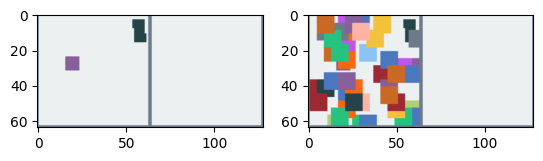

[-14.288]


In [7]:
env = envs.PWDestroyEnv(batch_size=1, device=device)
obs = env.reset()
plt.subplot(121)
plt.imshow(env.render())
for _ in tqdm(range(63)):
    obs, reward, done, info = env.step(env.action_space.sample())
plt.subplot(122)
plt.imshow(env.render())
plt.show()
obs, reward, done, info = env.step(env.action_space.sample())
print(reward)

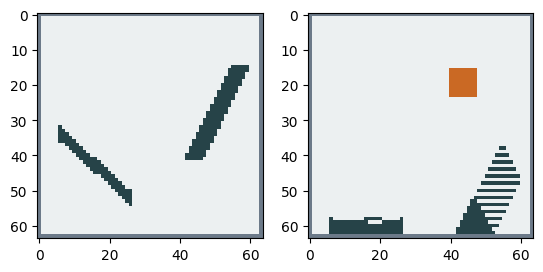

In [12]:
plt.subplot(121)
plt.imshow(pwr.render(torch.from_numpy(obs[:, :20]).to(device)))
plt.subplot(122)
plt.imshow(pwr.render(torch.from_numpy(obs[:, 20:]).to(device)))

In [13]:
env.observation_space.sample().shape

(40, 64, 64)

In [5]:
from stable_baselines3 import PPO, DQN
import torch.nn as nn

from stable_baselines3.common.vec_env import VecMonitor, VecVideoRecorder
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space, features_dim=256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten()
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            obs = torch.as_tensor(observation_space.sample()).float()
            n_flatten = self.cnn(obs[None]).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )
        
    def forward(self, observations):
        return self.linear(self.cnn(observations))

In [8]:
import wandb
from wandb.integration.sb3 import WandbCallback
wandb.finish()

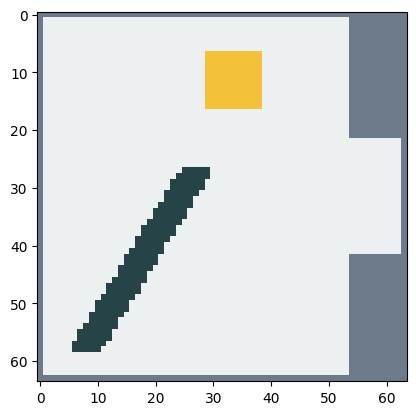

In [24]:
env = envs.PWSandEnv(False, None, device=device)
env.reset()
plt.imshow(env.render())

In [ ]:
def train_agent():
    run = wandb.init(
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        monitor_gym=True,
        save_code=True)
    
    num_elems = 2
    all_elems = ['empty', 'sand', 'water', 'wall', 'plant', 'stone', 'lava']
    elems = all_elems[:num_elems]
    
    kwargs_pcg = dict(hw=(64,64), elems=elems, num_tasks=100000, num_lines=1, num_circles=1, num_squares=1, has_empty_path=False)
    # env = envs.PWSandEnv(False, kwargs_pcg, device=device)
    env = envs.PWDrawEnv(False, kwargs_pcg, device=device)
    env = VecMonitor(env)
    env = VecVideoRecorder(env, f"videos/{run.id}", record_video_trigger=lambda x: x % 2000 == 0, video_length=500)
    
    policy_kwargs = dict(
        features_extractor_class=CustomCNN,
        features_extractor_kwargs=dict(features_dim=20),
    )
    
    model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, n_steps=64, batch_size=64, verbose=1, tensorboard_log=f"runs/{run.id}")
    callback = WandbCallback(gradient_save_freq=10000, model_save_path=f"models/{run.id}", verbose=2)
    model.learn(total_timesteps=500_000, callback=callback)
    run.finish()
    
train_agent()

Using cuda device


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to runs/10qdeipw/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -2.2849  |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 72       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | -2.0751     |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 161         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017591093 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.4       |
|    explained_variance   | 0.0134      |

In [30]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced
Thread HandlerThread:
Traceback (most recent call last):
  File "/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 50, in run
    self._run()
  File "/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 97, in _run
    record = self._input_record_q.get(timeout=1)
  File "/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/multiprocessing/queues.py", line 117, in get
    res = self._recv_bytes()
  File "/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/multiprocessing/connection.py", line 217, in recv_bytes
    self._check_closed()
  File "/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/multiprocessing/connection.py", line 141, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed
